In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

pd.set_option('precision', 3)

In [110]:
def Get_Title(row):
    step1 = row['Name'].split(',', 1)
    step2 = step1[1].split('.', 1)
    
    return step2[0]

def Get_Surname(row):
    step1 = row['Name'].split(',', 1)
    
    return step1[0]

def Get_Names(row):
    step1 = row['Name'].split(',', 1)
    step2 = step1[1].split('.', 1)
    
    return step2[1]

def Get_Deck(code):
    if isinstance(code, str):
        return code[0]
    
def Twin_HASH(row):
    surname = row['Surname']
    age = row['Age']
    sibl = row['SibSp']
    
    return str(age) + surname + str(sibl)

In [111]:
train_csv = pd.read_csv('../input/train.csv')

In [112]:
train_csv['Title'] = train_csv.apply(lambda x: Get_Title(x), axis=1)
train_csv['Surname'] = train_csv.apply(lambda x: Get_Surname(x), axis=1)
train_csv['Names'] = train_csv.apply(lambda x: Get_Names(x), axis=1)
train_csv['Deck'] = train_csv['Cabin'].apply(lambda x: Get_Deck(x))
#train_csv['TH'] = train_csv.apply(lambda x: Twin_HASH(x), axis=1)

In [113]:
colNames = {
    'PassengerId' : 'id',
    'Survived'    : 'Survived',
    'Pclass'      : 'Class',
    'Embarked'    : 'POL'
}

train_csv.rename(columns=colNames, inplace=True)
train_csv.drop('Name', axis=1, inplace=True)

In [114]:
train_csv.set_index('id',inplace=True)

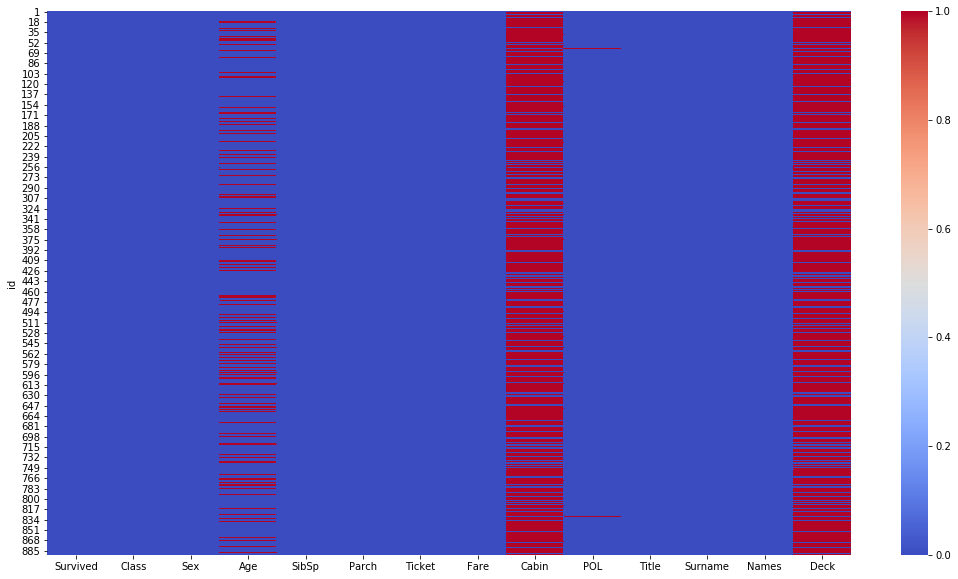

In [115]:
plt.figure(figsize=(18,10))
sns.heatmap(train_csv.isna(), cmap='coolwarm')

In [116]:
train_csv[train_csv['POL'].isna() == True]

,Survived,Class,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,POL,Title,Surname,Names,Deck
id,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss,Icard,Amelie,B
830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Stone,George Nelson (Martha Evelyn),B


In [117]:
train_csv[(train_csv['Fare'] > 75) & (train_csv['Fare'] < 85) & (train_csv['Deck'] == 'B')]

,Survived,Class,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,POL,Title,Surname,Names,Deck
id,,,,,,,,,,,,,,
62,1,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss,Icard,Amelie,B
140,0,1,male,24.0,0,0,PC 17593,79.2,B86,C,Mr,Giglio,Victor,B
588,1,1,male,60.0,1,1,13567,79.2,B41,C,Mr,Frolicher-Stehli,Maxmillian,B
790,0,1,male,46.0,0,0,PC 17593,79.2,B82 B84,C,Mr,Guggenheim,Benjamin,B
830,1,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Stone,George Nelson (Martha Evelyn),B


In [118]:
train_csv['POL'].fillna('C', inplace=True)

In [119]:
train_csv[train_csv['Age'].isna() == True]['Sex'].value_counts()

male      124
female     53
Name: Sex, dtype: int64

In [120]:
train_csv[train_csv['Age'].isna() == True]['Class'].value_counts()

3    136
1     30
2     11
Name: Class, dtype: int64

In [121]:
pd.crosstab(train_csv[train_csv['Age'].isna() == True]['Sex'], train_csv[train_csv['Age'].isna() == True]['Class'])

Class,1,2,3
Sex,,,
female,9,2,42
male,21,9,94


In [122]:
pd.crosstab(train_csv['Sex'], train_csv['Class'], train_csv['Age'], aggfunc=['mean', 'std'])

mean                     std               
Class        1       2       3       1       2      3
Sex                                                  
female  34.612  28.723  21.750  13.612  12.873  12.73
male    41.281  30.741  26.508  15.140  14.794  12.16

In [123]:
# model which predicts the person's age based on:
# Class
# Sex
# Parch
# SibSp

def Get_DFs(df):
    
    index_null     = df[df['Age'].isnull() == True].index
    index_not_null = df[df['Age'].isnull() == False].index
    
    train = pd.DataFrame(index=index_not_null)
    infer = pd.DataFrame(index=index_null)
    
    train['Class'], junk = df.loc[index_not_null,'Class'].factorize()
    train['Sex'], junk   = df.loc[index_not_null,'Sex'].factorize()
    train['Parch'], junk = df.loc[index_not_null,'Parch'].factorize()
    train['SibSp'], junk = df.loc[index_not_null,'SibSp'].factorize()
    train['Age']         = df.loc[index_not_null,'Age']
    
    infer['Class'], junk = df.loc[index_null,'Class'].factorize()
    infer['Sex'], junk   = df.loc[index_null,'Sex'].factorize()
    infer['Parch'], junk = df.loc[index_null,'Parch'].factorize()
    infer['SibSp'], junk = df.loc[index_null,'SibSp'].factorize()
    
    return train, infer

In [124]:
train, infer = Get_DFs(train_csv)

In [125]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [126]:
tree.fit(train.drop('Age', axis=1), train['Age'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [127]:
infer['Age'] = tree.predict(infer)

In [128]:
train_csv.loc[infer.index,'Age'] = infer['Age']

In [129]:
from sklearn.ensemble import GradientBoostingClassifier

In [130]:
gboost = GradientBoostingClassifier(n_estimators=95,learning_rate=0.11,max_depth=4,min_samples_split=10)

In [131]:
train_csv.head()

,Survived,Class,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,POL,Title,Surname,Names,Deck
id,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.250,NaN,S,Mr,Braund,Owen Harris,None
2,1,1,female,38.0,1,0,PC 17599,71.283,C85,C,Mrs,Cumings,John Bradley (Florence Briggs Thayer),C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Miss,Heikkinen,Laina,None
4,1,1,female,35.0,1,0,113803,53.100,C123,S,Mrs,Futrelle,Jacques Heath (Lily May Peel),C
5,0,3,male,35.0,0,0,373450,8.050,NaN,S,Mr,Allen,William Henry,None


In [132]:
def factor(df):
    df['Class'], junk = df['Class'].factorize()
    df['SibSp'], junk = df['SibSp'].factorize()
    df['Sex'], junk   = df['Sex'].factorize()
    df['Parch'], junk = df['Parch'].factorize()
    df['POL'], junk   = df['POL'].factorize()

In [133]:
factor(train_csv)

gboost.fit(
    train_csv.drop(
        [
            'Survived', 
            'Cabin', 
            'Deck', 
            'Title', 
            'Names', 
            'Surname',
            'Ticket'
        ], axis=1), 
    train_csv['Survived'])

X_train = train_csv.drop(
        [
            'Survived', 
            'Cabin', 
            'Deck', 
            'Title', 
            'Names', 
            'Surname',
            'Ticket'
        ], axis=1) 

y_train = train_csv['Survived']

In [134]:
predictions = gboost.predict(
    train_csv.drop(
        [
            'Survived', 
            'Cabin', 
            'Deck', 
            'Title', 
            'Names', 
            'Surname',
            'Ticket'
        ], axis=1), 
)

In [135]:
from sklearn.metrics import confusion_matrix, classification_report

In [136]:
confusion_matrix(train_csv['Survived'], predictions)

array([[536,  13],
       [ 53, 289]], dtype=int64)

In [137]:
print(classification_report(train_csv['Survived'], predictions))

             precision    recall  f1-score   support

          0       0.91      0.98      0.94       549
          1       0.96      0.85      0.90       342

avg / total       0.93      0.93      0.92       891



In [139]:
test_csv = pd.read_csv('../input/test.csv')

In [140]:
test_csv.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.287,NaN,S


In [141]:
index = test_csv[test_csv['Age'].isnull() == True].index

colNames = {
    'PassengerId' : 'id',
    'Survived'    : 'Survived',
    'Pclass'      : 'Class',
    'Embarked'    : 'POL'
}

test_csv.rename(columns=colNames, inplace=True)

infer = pd.DataFrame(index=index)
infer['Class'], junk = test_csv.loc[index, 'Class'].factorize()
infer['Sex'], junk   = test_csv.loc[index, 'Sex'].factorize()
infer['SibSp'], junk = test_csv.loc[index, 'SibSp'].factorize()
infer['Parch'], junk = test_csv.loc[index, 'Parch'].factorize()


infer['Age'] = tree.predict(infer)

test_csv.loc[infer.index,'Age'] = infer['Age']
test_csv.set_index('id', inplace=True)

In [142]:
test_csv.head(10)

,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,POL
id,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.829,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.688,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.662,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.287,NaN,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.225,NaN,S
898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.629,NaN,Q
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.000,NaN,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.229,NaN,C


In [143]:
train_csv.head(2)

,Survived,Class,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,POL,Title,Surname,Names,Deck
id,,,,,,,,,,,,,,
1,0,0,0,22.0,0,0,A/5 21171,7.250,NaN,0,Mr,Braund,Owen Harris,None
2,1,1,1,38.0,0,0,PC 17599,71.283,C85,1,Mrs,Cumings,John Bradley (Florence Briggs Thayer),C


In [144]:
mean_fare = test_csv['Fare'].mean()
index = test_csv[test_csv['Fare'].isnull() == True].index
test_csv.loc[index,'Fare'] = mean_fare

factor(test_csv)

predictions = gboost.predict(
    test_csv.drop(
        [
            'Cabin', 
            'Ticket',
            'Name'
        ], axis=1))

In [145]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [146]:
test_csv.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='id', length=418)

In [147]:
submission = pd.DataFrame(index=test_csv.index)

In [148]:
submission['Survived'] = predictions

In [149]:
submission.head()

,Survived
id,
892,0
893,0
894,0
895,0
896,1


In [151]:
submission.to_csv('submission-01.csv')